# Transfer Learning Exercise
---

> ### Important
> Some of the functions and cells used were taken from example notebooks present on complementary material for this exercise.

##### This notebook features a discussion of results at the end.

In [1]:
%matplotlib inline

import os

import random
import numpy as np
import glob
import keras
import sys
from shutil import copyfile

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Downloading the Dataset

The dataset used is from [Kaggle](https://www.kaggle.com/datasets/noodulz/pokemon-dataset-1000), and it features:
- 1.000 different Pokémon species
- ~40 images per species
- Each image has 128x128 pixels 

Due to the simple nature of this notebook and the exercise behind it. Data augmentation wasn't used, contrary to the dataset's author recommendation.

In [3]:
import kagglehub

path = kagglehub.dataset_download("noodulz/pokemon-dataset-1000")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/noodulz/pokemon-dataset-1000/versions/2


## Creating the folders

In [4]:
def makedir(string):
    try:
        os.mkdir(string)
    except OSError:
        pass

In [5]:
prefix = '/tmp/pokemon/'
midfix  = '/training'
midfix2 = '/testing'
cat = [x[101:] for x in glob.glob(path + '/pokemon-dataset-1000/dataset/*')]

makedir(prefix)
makedir(prefix + midfix)
makedir(prefix + midfix2)

for i in cat:
    makedir(prefix + midfix + '/' + i)
    makedir(prefix + midfix2 + '/' + i)

## Organizing data into folders

In [6]:
split = 0.9

for i in cat:
    images = glob.glob(path + f'/pokemon-dataset-1000/dataset/{i}/*.png')

    random.shuffle(images)

    size_training = int(len(images) * split)
    training_set = images[0: size_training]
    testing_set = images[size_training:]

    for item in training_set:
        png = item[item.rfind('/') + 1:]
        copyfile(item, prefix + midfix + '/' + i + '/' + png)

    for item in testing_set:
        png = item[item.rfind('/') + 1:]
        copyfile(item, prefix + midfix2 + '/' + i + '/' + png)

## Creating Flow

In [7]:
train_datagen = ImageDataGenerator(rescale=1.0/255.)
traingen = train_datagen.flow_from_directory(prefix + midfix + '/',
                                             batch_size = 250,
                                             target_size=(224,224))

valid_datagen = ImageDataGenerator(rescale=1.0/255.)
validgen = valid_datagen.flow_from_directory(prefix + midfix + '/',
                                             batch_size = 250,
                                             target_size=(224,224))

Found 26217 images belonging to 1000 classes.
Found 26217 images belonging to 1000 classes.


## First model used

In [11]:
# build the network
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(len(cat)))
model.add(Activation('softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1000)                │         257,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 1000)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,465,544 (5.59 MB)

 Trainable params: 1,465,544 (5.59 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(traingen,
                    epochs=10,
                    validation_data=validgen)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.0019 - loss: 6.8426 - val_accuracy: 0.0470 - val_loss: 6.1849
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 94s 998ms/step - accuracy: 0.0499 - loss: 5.8495 - val_accuracy: 0.3715 - val_loss: 3.9567
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.2235 - loss: 4.1854 - val_accuracy: 0.6532 - val_loss: 2.2051
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.3898 - loss: 3.0292 - val_accuracy: 0.8039 - val_loss: 1.2708
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 141s 996ms/step - accuracy: 0.5139 - loss: 2.2767 - val_accuracy: 0.8687 - val_loss: 0.8938
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 142s 996ms/step - accuracy: 0.5973 - loss: 1.7842 - val_accuracy: 0.9142 - val_loss: 0.5586
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 142s 992ms/step - accuracy: 0.6584 - loss: 1.4777 - val_accuracy: 0.9342 - val_loss: 0.4299
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 93s 984ms/step - accuracy: 0.6927 - loss: 1.2917 - val_accuracy:

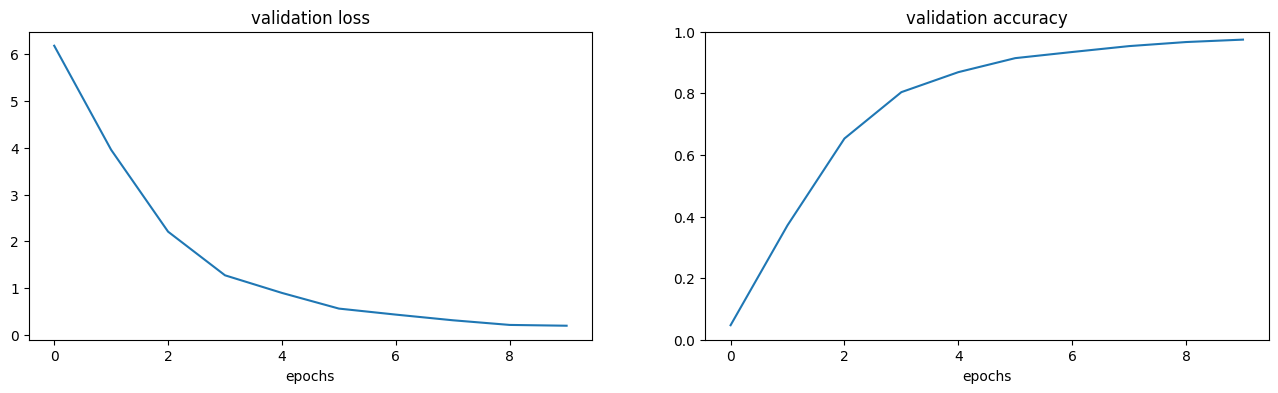

In [13]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [19]:
model.save_weights('No_transfer_learning.weights.h5')

# Transfer Learning

In [14]:
# Necessary to clear GPU RAM
import gc
gc.collect()

3605

In [8]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(len(cat), activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [10]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary

<bound method Model.summary of <Functional name=functional, built=True>>

In [11]:
history2 = model_new.fit(traingen,
                         epochs=10,
                         validation_data=validgen)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.0105 - loss: 7.7843 - val_accuracy: 0.0774 - val_loss: 6.0623
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.1069 - loss: 5.7958 - val_accuracy: 0.2134 - val_loss: 4.9927
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.2169 - loss: 4.8938 - val_accuracy: 0.2852 - val_loss: 4.2750
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.3009 - loss: 4.2200 - val_accuracy: 0.3737 - val_loss: 3.7117
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.3972 - loss: 3.6485 - val_accuracy: 0.4612 - val_loss: 3.2694
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.4567 - loss: 3.2711 - val_accuracy: 0.5032 - val_loss: 2.9738
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.5141 - loss: 2.9103 - val_accuracy: 0.5338 - val_loss: 2.7296
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.5431 - loss: 2.6877 - val_accu

In [15]:
model_new.save_weights('With_transfer_learning.weights.h5')

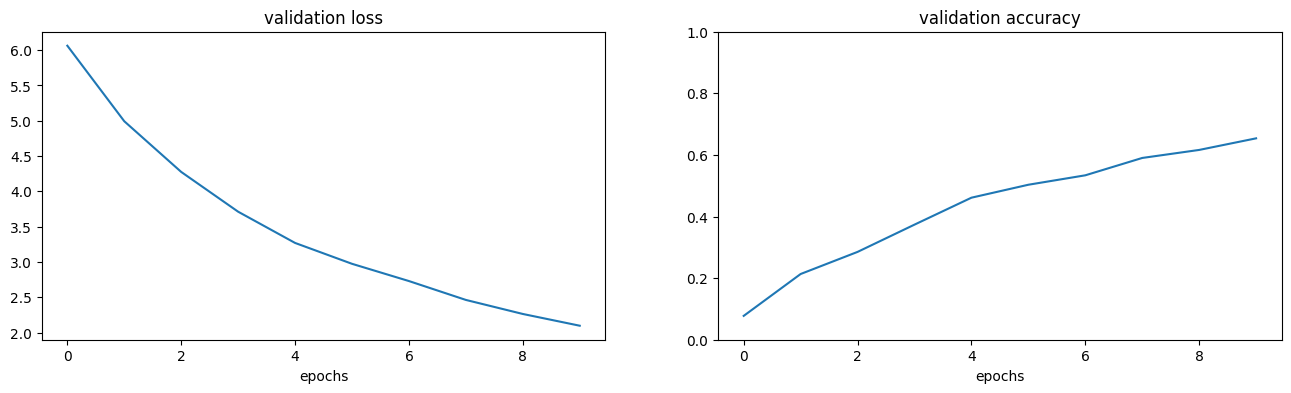

In [13]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

# Discussing Results

- The first model got ``0.7573`` accuracy, while the second reached ``0.6183``.
- We can conclude that transfer learning did not help in this problem, although a low amount of epochs was used, meaning that the difference in those results could increase.
    - Transfer learning is often used when the model could learn the necessary information through more general data, ex. telling cats and dogs apart. It shines more when the information is useful for the specific data, ex. breeds of cats and dogs
    - Due to simplicity, the output layer was the only one removed. No tests of the removal of more layers were made.
- The first model has a simpler architecture than the second, meaning it took less time for training and got a better result.